In [43]:
#@title Imports and Helper Functions
import numpy as np
import pickle
from matplotlib import pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import requests
import random

# save to website only works on mac, in theory you could download my best models from 
# www.aayanarish.com/ml_models/linclass/aayan_mnist.pkl and cifar similarily
SAVE_TO_WEBSITE = False
SAVE_PATH = "ml/ml_models/linclass/" if SAVE_TO_WEBSITE else ""

class Model:
    """Base class for models."""
    def __init__(self):
        """params is a dictionary mapping parameter names to numpy arrays"""
        self.params = {}

    def predict(self, X):
        """X is a numpy array of shape (N, D), where N is the number of
        D-dimensional data points"""
        raise NotImplementedError

    def loss(self, X, y):
        """X is a numpy array of shape (N, D) and y is a numpy array of shape (N,)"""
        raise NotImplementedError

    def grad(self, X, y):
        """X is a numpy array of shape (N, D) and y is a numpy array of shape (N,).
        This will be a matching dictionary to self.params, with all the same keys
        and for each parameter it will have the gradient which is a numpy array of
        the same shape"""
        raise NotImplementedError

def grad_check(model, X, y, eps = 1e-6):
    """Numerically estimate the gradient of the loss function and compare it to the analytical gradient"""
    grad = model.grad(X, y)
    for param in model.params:
        print(f"Checking {param}:")
        print(f"Analytical gradient {grad[param]}")
        assert grad[param].shape == model.params[param].shape, "Gradient shape mismatch"
        numgrad = np.zeros(grad[param].shape)
        for i, val in np.ndenumerate(model.params[param]):
            model.params[param][i] = val + eps
            loss1 = model.loss(X, y)
            model.params[param][i] = val - eps
            loss2 = model.loss(X, y)
            model.params[param][i] = val
            numgrad[i] = (loss1 - loss2) / (2 * eps)
        print(f"Numerical gradient {numgrad}")
        print(f"Difference {abs(numgrad - grad[param])}")
        print()

class Optimizer:
    def __init__(self, model):
        self.model = model

    def step(self, grad):
        raise NotImplementedError

class SGD(Optimizer):
    def __init__(self, model, learning_rate=1e-3):
        super().__init__(model)
        self.learning_rate = learning_rate

    def step(self, grad):
        for param in self.model.params:
            self.model.params[param] -= self.learning_rate * grad[param]

class Adam(Optimizer):
    def __init__(self, model, D, b1, b2, lr, off=1e-7):
        super().__init__(model)
        self.b1 = b1
        self.b2 = b2
        self.lr = lr
        self.off = off
        self.first_mom = {"W":np.zeros(D, dtype=float), "b":np.array(0, dtype=float)}
        self.second_mom = {"W":np.zeros(D, dtype=float), "b":np.array(0, dtype=float)}
        self.t = 0
    
    def step(self, grad):
        self.t += 1
        for param in self.model.params:
            self.first_mom[param] = self.b1*self.first_mom[param] + (1-self.b1) * grad[param]
            self.second_mom[param] = self.b2*self.second_mom[param] + (1-self.b2) * (grad[param]**2)
            first_unbias = self.first_mom[param] / (1-self.b1**self.t)
            second_unbias = self.second_mom[param] / (1-self.b2**self.t)
            self.model.params[param] -= self.lr*first_unbias / (np.sqrt(second_unbias)+self.off)

        

def train(model, X_train, y_train, num_epochs = 50,
          print_every = 1,
          batch_size = None, optimizer = None,
          X_val = None, y_val = None,
          save_path='best_model.pkl'):

    if optimizer is None:
        optimizer = SGD(model)
    if batch_size is None:
        batch_size = X_train.shape[0]

    if X_val is not None:
        best_val_acc = np.mean(model.classify(X_val) == y_val)

    for epoch in range(num_epochs):

        if epoch % print_every == 0:
            print(f"Epoch {epoch}:")
            print(f"Train Loss = {model.loss(X_train, y_train)}")
            print(f"Train Accuracy = {np.mean(model.classify(X_train) == y_train)}")
            if X_val is not None:
                print(f"Val Loss = {model.loss(X_val, y_val)}")
                val_acc = np.mean(model.classify(X_val) == y_val)
                print(f"Val Accuracy = {val_acc}")
                if val_acc > best_val_acc:
                    best_val_acc = val_acc
                    with open(save_path, 'wb') as f:
                        pickle.dump(model, f)

        # split into batches and loop over batches
        indices = np.random.permutation(X_train.shape[0])
        num_batches = X_train.shape[0] // batch_size
        batch_indices = np.array_split(indices, num_batches)
        for batch in batch_indices:
            optimizer.step(model.grad(X_train[batch], y_train[batch]))



# Part 1: Binary Classifiers

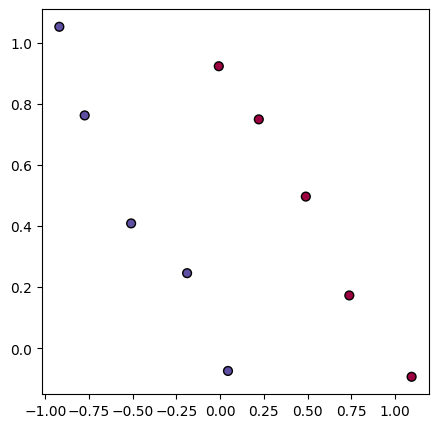

In [44]:
def plot_2d_data(X, y):
    fig, ax = plt.subplots(figsize = (5, 5))
    ax.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral, edgecolors='black')

def plot_2d_classifier(X, y, classifier):
    """Makes a scatter plot of the data points and a background of what the classifier does.
    X is a (n,2) array of data points.
        y is an (n,) array of labels.
        classifier is a function that takes a 2d points
         and gives a label."""
    border = 0.2
    x_min, x_max = X[:, 0].min() - border, X[:, 0].max() + border
    y_min, y_max = X[:, 1].min() - border, X[:, 1].max() + border
    num_points = 100
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, num_points),
                        np.linspace(y_min, y_max, num_points))
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    classes = classifier(grid_points)
    classes = classes.reshape(xx.shape)
    fig = plt.figure(figsize = (6,6))
    plt.contourf(xx, yy, classes, 3, cmap=plt.cm.Spectral, alpha=1)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral, edgecolors='black')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

def visualize_weights(m):
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))

    for i, ax in enumerate(axes.flat):
        im = ax.imshow(m.params['W'][:,i].reshape(28, 28),
                      cmap='RdBu_r',
                      norm=TwoSlopeNorm(vcenter=0))
        plt.colorbar(im, ax=ax)
        ax.set_title(f'Weights for {i}')
        # Remove axis numbers
        ax.set_xticks([])
        ax.set_yticks([])

    plt.tight_layout()
    plt.show()

def visualize_weights_cifar(m):
    classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    wmin, wmax = np.min(m.params['W']), np.max(m.params['W'])
    for i, ax in enumerate(axes.flat):
        im = ax.imshow((m.params['W'][:,i].reshape(32, 32, 3) - wmin) / (wmax - wmin))
        ax.set_title(f'Weights for {classes[i]}')
        # Remove axis numbers
        ax.set_xticks([])
        ax.set_yticks([])

    plt.tight_layout()
    plt.show()

X1 = np.array([[ 1.09552218, -0.09272374],
       [ 0.73918262,  0.17328342],
       [ 0.49026465,  0.49654933],
       [ 0.22117347,  0.74908991],
       [-0.00771262,  0.9228498 ],
       [ 0.04485428, -0.07363758],
       [-0.18909266,  0.24609735],
       [-0.50931804,  0.40888908],
       [-0.77501111,  0.76200558],
       [-0.92010407,  1.0518896 ]])
y1 = np.array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])

plot_2d_data(X1, y1)

## Naive attempt: just use multiple regression

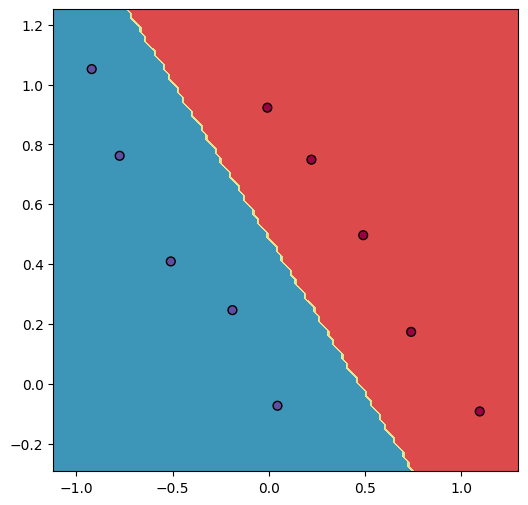

In [45]:
class MultipleRegression(Model):
    def __init__(self, D, reg=0):
        super().__init__()
        W = np.zeros(D, dtype=float)
        b = np.array(0, dtype=float)
        self.reg = reg
        self.params = {"W": W, "b": b}

    def predict(self, X):
        return X @ self.params['W'] + self.params['b']

    def loss(self, X, y):
        loss = np.mean((self.predict(X) - y) ** 2)
        loss += self.reg * np.sum(self.params['W'] ** 2)
        return loss

    def grad(self, X, y):
        dW = ((2*self.predict(X)-2*y) @ X)/len(X) + (self.reg * 2 * (self.params['W']))
        db = np.array(2*np.mean(self.predict(X)-y))
        return {"W": dW, "b": db}
    
    def fit(self, X, y):
        X_2 = X
        if (X_2.shape[1] == len(self.params['W'])):
            X_2 = np.pad(X, ((0, 0), (0, 1)), mode="constant", constant_values=1)
        mn = np.linalg.inv(X_2.T @ X_2 + np.pad(np.identity(len(X_2.T)-1, dtype=float), ((0, 1), (0, 1)), mode="constant", constant_values=0)*self.reg*len(X_2) ) @ (y @ X_2)
        self.params["W"] = mn[:-1]
        self.params["b"] = np.array(mn[-1])
    
    def classify(self, X):
        return self.predict(X) > 0.5

# you can then fit X1 and y1 and see the result using
m = MultipleRegression(2, 0)
m.fit(X1, y1)
plot_2d_classifier(X1, y1, m.classify)

This first example should actually work pretty well. To see why this method is more generally flawed, here's another dataset:

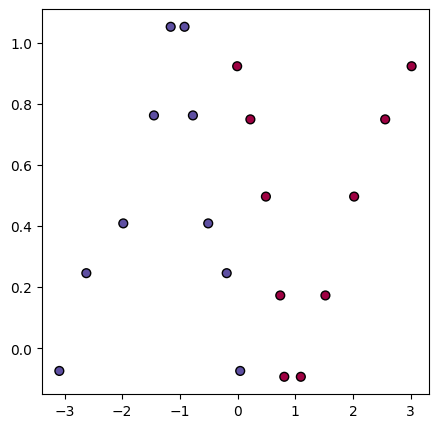

In [46]:
X2 = np.array([[ 0.80895564, -0.09272374],
       [ 1.52163476,  0.17328342],
       [ 2.0194707 ,  0.49654933],
       [ 2.55765306,  0.74908991],
       [ 3.01542524,  0.9228498 ],
       [-3.08970856, -0.07363758],
       [-2.62181468,  0.24609735],
       [-1.98136392,  0.40888908],
       [-1.44997778,  0.76200558],
       [-1.15979186,  1.0518896 ]])
X2 = np.concatenate([X1, X2])
y2 = np.concatenate([y1, y1])

plot_2d_data(X2, y2)

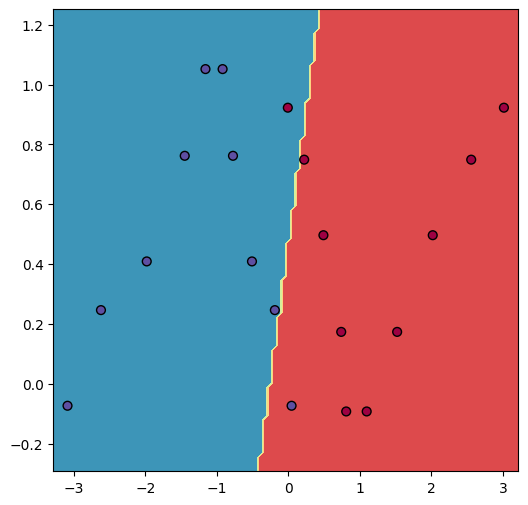

In [47]:
m = MultipleRegression(2, 0)
m.fit(X2, y2)
plot_2d_classifier(X2, y2, m.classify)

## Actual Solution: Logistic "Regression"

Epoch 0:
Train Loss = 0.6931471805599453
Train Accuracy = 0.5
Epoch 20:
Train Loss = 0.01454348585273189
Train Accuracy = 1.0
Epoch 40:
Train Loss = 0.0059932838865347235
Train Accuracy = 1.0
{'W': array([0.00171896, 0.00026171]), 'b': -4.3296126880555155e-05}


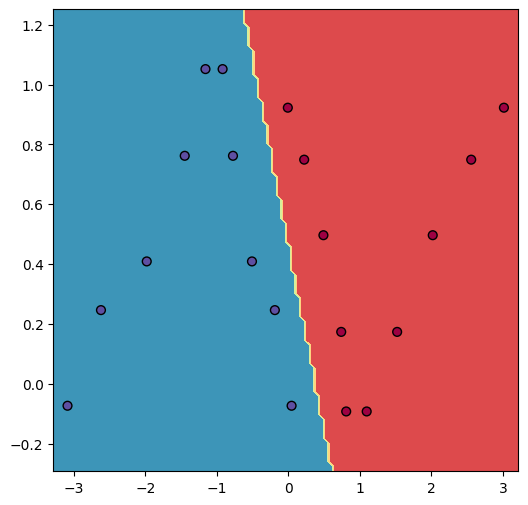

In [48]:
def sigmoid(t):
    return 1/(1+np.e**(-t))

class LogisticRegression(MultipleRegression):

    def classify(self, X):
        return self.predict(X) > 0

    def loss(self, X, y):
        # -np.log(np.where(y, self.probs(X), 1-self.probs(X))).mean()
        prbs = [p if y_i > 0 else 1-p for (p, y_i) in zip(self.probs(X), y)]
        ls = -np.log(prbs).mean()
        return ls
    
    def grad(self, X, y):
        alpha = self.probs(X)
        dw = -np.mean([(1-a)*x if y_i > 0 else -a*x for (a, x, y_i) in zip(alpha, X, y)], axis=0)
        db = -np.mean([(1-a) if y_i > 0 else -a for (a, y_i) in zip(alpha, y)])
        return {"W" : dw, "b" : db}

    def probs(self, X):
        return sigmoid(self.predict(X))
    

    
m = LogisticRegression(2, 0)
train(m, X2, y2, print_every=20, optimizer=Adam(m, 2, 0.9, 0.99, 1))
plot_2d_classifier(X2, y2, m.classify)
print(m.grad(X2, y2))

# Part 2: Linear Classifier on 2D Test Data

Get an 2D X and y with where now y has more than 2 possible classes. A good example is the very first dataset you created back on the first assignment, which should look something like this:

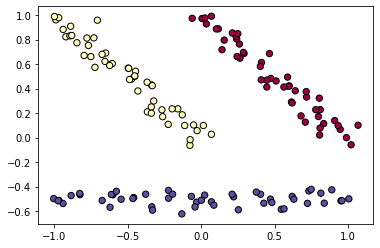

In [49]:
def softmax(arr):
    return (np.e**arr)/np.sum(np.e**arr, axis=1, keepdims=1)
class LinearClassifier(Model):
    def __init__(self, input_dim, output_dim, reg=0):
        W = np.zeros((input_dim, output_dim))
        b = np.zeros(output_dim)
        self.params = {'W': W, 'b': b}
        self.reg = reg

    def predict(self, X):
        return X @ self.params['W'] + self.params['b']

    def classify(self, X):
        scores = self.predict(X)
        return np.argmax(scores, axis=1)
    
    def _correct(self, X, y):
        # my way of doing it, slightly slower but i like it (will change if speed needed)
        alpha = softmax(self.predict(X))
        a2 = ((np.arange(alpha.shape[1])[:, None] == y)*1.0).T
        return np.sum(a2*alpha, axis=1), alpha, a2

    def loss(self, X, y):
        err = -np.log(self._correct(X, y)[0]).mean()
        # err = -np.log(alpha[np.arange(len(X)), y]).mean()
        err += self.reg * np.sum(self.params['W']**2)
        return err

    def grad(self, X, y):
        # i spent too long bashing my head at this
        _, alpha, a2 = self._correct(X, y)
        dscores = np.where(a2, alpha-1, alpha)
        dw = ((X.T @ dscores) / len(X)) + (self.reg * 2 * (self.params['W']))
        db = np.sum(dscores, axis=0) / len(X)
        return {"W" : dw, "b": db}
    



Checking W:
Analytical gradient [[ 0.43993869  0.07721268 -0.51715137]
 [ 0.24861897  0.02586607 -0.27448504]]
Numerical gradient [[ 0.43993869  0.07721268 -0.51715137]
 [ 0.24861897  0.02586607 -0.27448504]]
Difference [[4.24132951e-11 5.40102962e-11 1.31568090e-11]
 [1.63917213e-11 1.01849223e-11 7.70598030e-11]]

Checking b:
Analytical gradient [ 0.19868592  0.03111955 -0.22980546]
Numerical gradient [ 0.19868592  0.03111955 -0.22980546]
Difference [4.86592988e-11 5.90386628e-11 3.10799164e-11]

Epoch 0:
Train Loss = 0.4300811976262323
Train Accuracy = 0.75
Epoch 10:
Train Loss = 0.23336841243071293
Train Accuracy = 1.0
Epoch 20:
Train Loss = 0.17318190812326473
Train Accuracy = 1.0
Epoch 30:
Train Loss = 0.15004156268476418
Train Accuracy = 1.0
Epoch 40:
Train Loss = 0.13915422786542034
Train Accuracy = 1.0
Epoch 50:
Train Loss = 0.13297716478775876
Train Accuracy = 1.0
Epoch 60:
Train Loss = 0.12887878147488308
Train Accuracy = 1.0
Epoch 70:
Train Loss = 0.12581834437391684
Train 

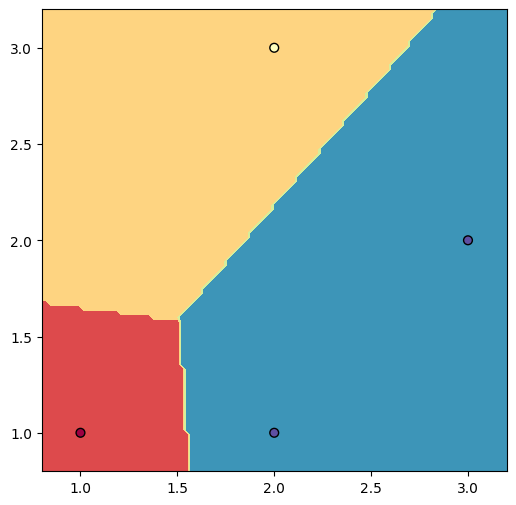

In [50]:
## A class example we will use
X3 = np.array([[1,1],
              [2,1],
              [3,2],
              [2,3]], dtype=float)
y3 = np.array([0,2,2,1])
m = LinearClassifier(2, 3)
m.params['W'] = np.array([[-2,-2,1],
                          [-1,2,-1]], dtype=float)
m.params['b'] = np.array([4,-2,-3], dtype=float)
grad_check(m, X3, y3)
train(m, X3, y3, num_epochs=100, optimizer=SGD(m, 0.05), print_every=10)
plot_2d_classifier(X3, y3, m.classify)

Epoch 0:
Train Loss = 1.0986122886681096
Train Accuracy = 0.3333333333333333
Epoch 50:
Train Loss = 0.0032341210481594564
Train Accuracy = 1.0


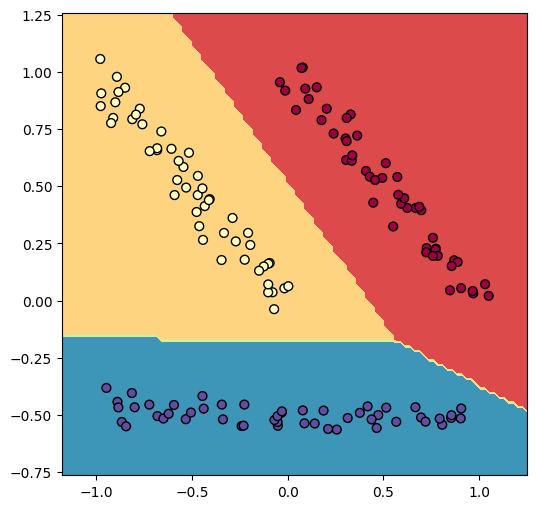

In [51]:
def make_cluster_data(num_points = 50, noise = 0.05,
                      line_points = [((1,0), (0,1)),
                                     ((0, 0), (-1, 1)),
                                     ((-1,-0.5), (1,-0.5))]):
    """Create num_points points linearly spaced between each pair of points in line_points,
    with a gaussian noise term added, where noise is the standard deviation."""
    n = num_points * len(line_points)
    points = np.zeros((n, 2))
    labels = np.zeros(n, dtype=int)
    ### Fill in the function
    rng = np.random.default_rng(16)
    pt = 0 # this is very not neccecary but cleaner
    for i in range(len(line_points)):
      dy, dx = (line_points[i][1][1] - line_points[i][0][1]), (line_points[i][1][0] - line_points[i][0][0])
      for j in range(num_points):
        offset_x, offset_y = rng.normal(scale=noise), rng.normal(scale=noise)
        x, y = line_points[i][0][0] + dx*(j/num_points), line_points[i][0][1] + dy*(j/num_points)
        points[pt][0] = x + offset_x
        points[pt][1] = y + offset_y
        labels[pt] = i
        pt += 1

    return points, labels
X4, y4 = make_cluster_data()
m = LinearClassifier(2, 3)
train(m, X4, y4, print_every=50, num_epochs=100, optimizer=Adam(m, 3, 0.9, 0.99, 1))
plot_2d_classifier(X4, y4, m.classify)

# Part 3: Linear Classifiers on MNIST / CIFAR-10

## Data Stuff

In [52]:
from keras.datasets import mnist, cifar10
(train_X_mnist, train_y_mnist), (test_X_mnist, test_y_mnist) = mnist.load_data()
(train_X_cifar, train_y_cifar), (test_X_cifar, test_y_cifar) = cifar10.load_data()

In [53]:
def train_test_split(*arrays, rng_seed = 16, percent_train = 0.8):
    rng = np.random.default_rng(seed=rng_seed)
    l = rng.permutation(len(arrays[0]))
    return [(i[l[:int(percent_train*len(i))]], i[l[int(percent_train*len(i)):]]) for i in arrays]

In [54]:
train_X_mnist = train_X_mnist.reshape((train_X_mnist.shape[0], 28*28))
test_X_mnist = test_X_mnist.reshape((test_X_mnist.shape[0], 28*28))
(train_X_mnist, val_X_mnist), (train_y_mnist, val_y_mnist) = train_test_split(train_X_mnist, train_y_mnist)

train_X_cifar = train_X_cifar.reshape((train_X_cifar.shape[0], 32*32*3))
train_y_cifar = train_y_cifar.flatten()
(train_X_cifar, val_X_cifar), (train_y_cifar, val_y_cifar) = train_test_split(train_X_cifar, train_y_cifar)

## Training

In [55]:
m = LinearClassifier(28*28, 10, 0)
train(m, train_X_mnist, train_y_mnist, num_epochs=10, print_every=1, batch_size=100, optimizer=Adam(m, 10, 0.9, 0.99, 0.00001), X_val=val_X_mnist, y_val=val_y_mnist, save_path=SAVE_PATH+"aayan_mnist.pkl")

Epoch 0:
Train Loss = 2.3025850929940455
Train Accuracy = 0.0995625
Val Loss = 2.3025850929940455
Val Accuracy = 0.09533333333333334
Epoch 1:
Train Loss = 0.31108254296521753
Train Accuracy = 0.9142291666666666
Val Loss = 0.3224273863137613
Val Accuracy = 0.9105833333333333
Epoch 2:
Train Loss = 0.2821226824784027
Train Accuracy = 0.9211875
Val Loss = 0.3016539185048135
Val Accuracy = 0.9170833333333334
Epoch 3:
Train Loss = 0.2738136321707042
Train Accuracy = 0.9231875
Val Loss = 0.2980095704949784
Val Accuracy = 0.9163333333333333
Epoch 4:
Train Loss = 0.26400916710983807
Train Accuracy = 0.9253333333333333
Val Loss = 0.29284444595462333
Val Accuracy = 0.91775
Epoch 5:
Train Loss = 0.2572705023782771
Train Accuracy = 0.9278541666666666
Val Loss = 0.2907840292931087
Val Accuracy = 0.9205833333333333
Epoch 6:
Train Loss = 0.25685177372728607
Train Accuracy = 0.9288958333333334
Val Loss = 0.29319679715695157
Val Accuracy = 0.9200833333333334
Epoch 7:
Train Loss = 0.24966599759056363
Tra

In [56]:
m2 = LinearClassifier(32*32*3, 10, 0.001)
train(m2, train_X_cifar, train_y_cifar, num_epochs=10, print_every=1, batch_size=1000, optimizer=Adam(m2, 10, 0.9, 0.99, 0.000001), X_val=val_X_cifar, y_val=val_y_cifar, save_path=SAVE_PATH+"aayan_cifar.pkl")

Epoch 0:
Train Loss = 2.3025850929940455
Train Accuracy = 0.09905
Val Loss = 2.3025850929940455
Val Accuracy = 0.1038
Epoch 1:
Train Loss = 1.9945063675748727
Train Accuracy = 0.311625
Val Loss = 1.992711845211322
Val Accuracy = 0.3061
Epoch 2:
Train Loss = 1.9156219646853871
Train Accuracy = 0.340675
Val Loss = 1.914857448423214
Val Accuracy = 0.339
Epoch 3:
Train Loss = 1.8761573583952602
Train Accuracy = 0.3559
Val Loss = 1.8787010318419615
Val Accuracy = 0.3524
Epoch 4:
Train Loss = 1.865062019797511
Train Accuracy = 0.343375
Val Loss = 1.8664673076930087
Val Accuracy = 0.3422
Epoch 5:
Train Loss = 1.83765228778966
Train Accuracy = 0.370175
Val Loss = 1.841579447458436
Val Accuracy = 0.3685
Epoch 6:
Train Loss = 1.8229427517394494
Train Accuracy = 0.377375
Val Loss = 1.8280048691882387
Val Accuracy = 0.3708
Epoch 7:
Train Loss = 1.815223518329466
Train Accuracy = 0.375375
Val Loss = 1.8237370612742678
Val Accuracy = 0.3663
Epoch 8:
Train Loss = 1.8000214239763803
Train Accuracy = 0

## Visualize Weights

### Mnist
faint outline for all the things, but good accuracy so yay! Technically not the best model since I'm not reading from file and the final params from training were not the very best (unless your train function always returns the model with the best paramters, but it didn't seem to), but the model is pretty much as representative. 

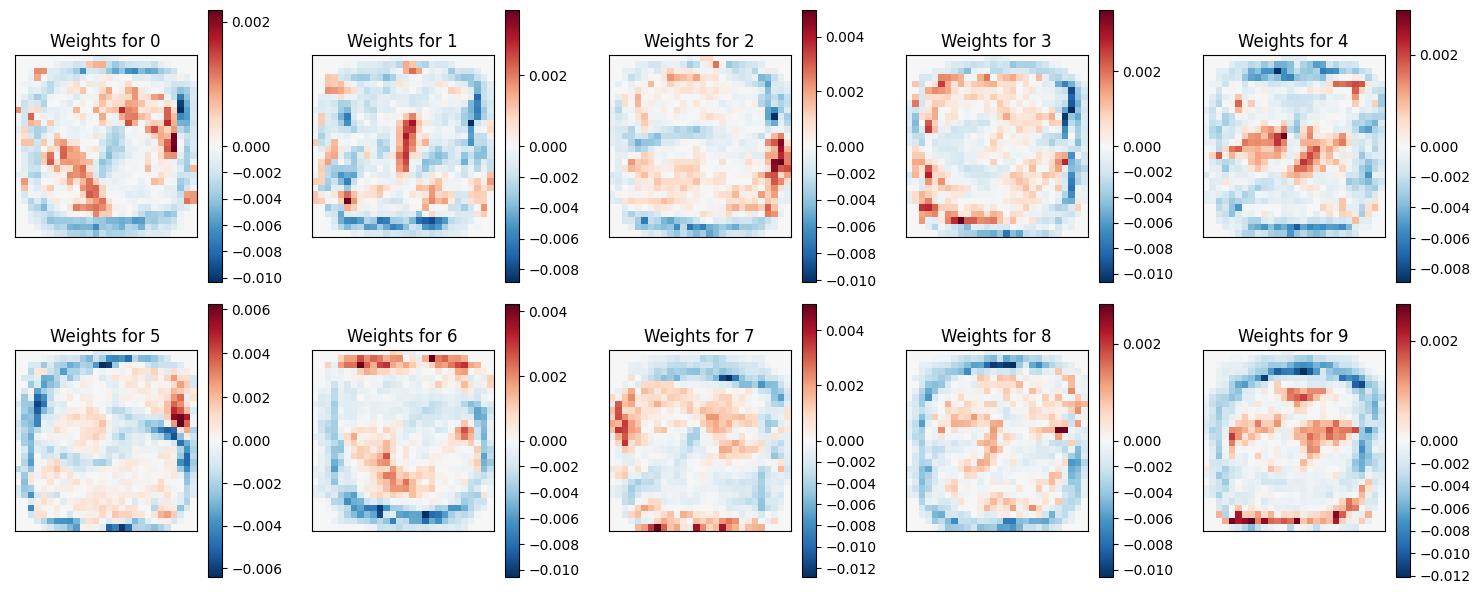

In [57]:
visualize_weights(m)

### Cifar
The ones for car and ship and horse are ok, but the rest are pretty bad. Very faint, but makes sense. Also rip bad accuracy. 

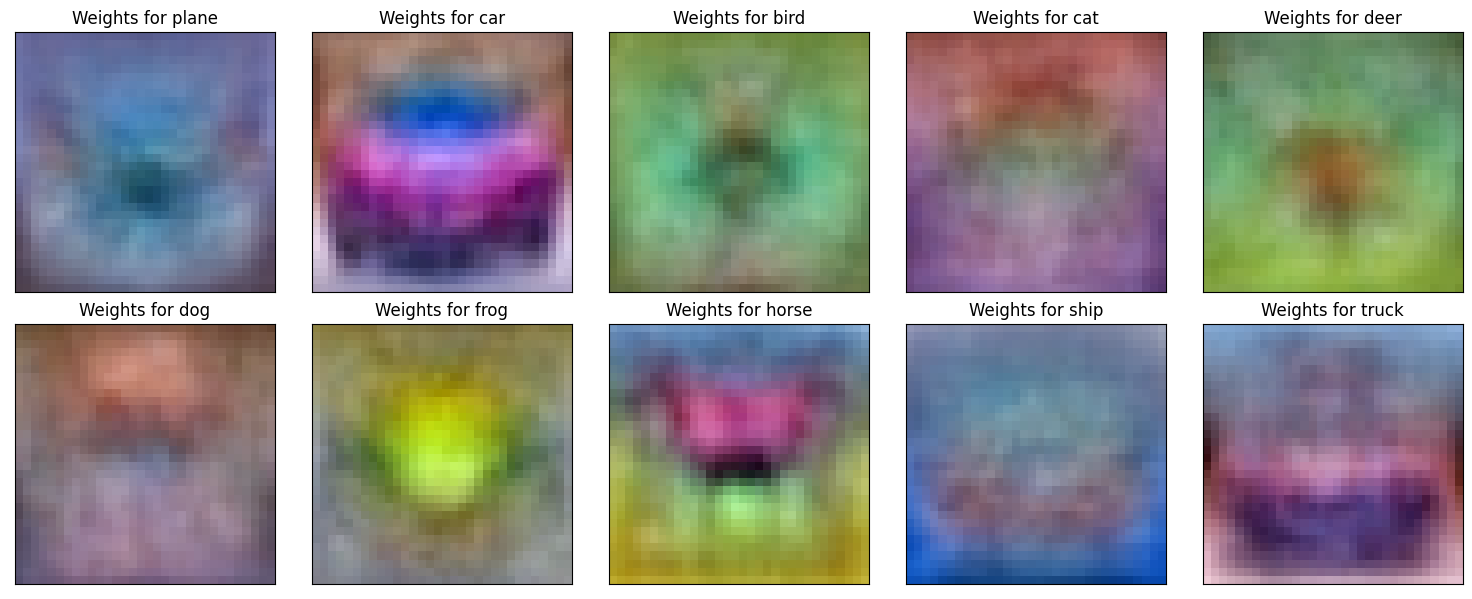

In [58]:
visualize_weights_cifar(m2)

# Part 4: Linear Classifiers on Word Dataset

Now we will see how to go interpret the bigram next token prediction as a linear model, and see solution the linear classifier finds

## Helpers

In [78]:
def get_token_dict(tokens):
    '''
    given a list of tokens, returns a dict of token to index in the array
    '''
    token_dct = {}
    for i in range(len(tokens)):
        token_dct[tokens[i]] = i
    return token_dct

def create_dataset(txt, ln, tokenFnc, letters):
    '''given list of words, and some input length, returns a huge list of datapoints'''
    X = []
    y = []
    for w in txt:
        w = "$" + w + "$"
        for i in range(len(w)-ln):
            # possible out of bounds, check
            inp = w[i:i+ln]
            out = w[i+ln]
            inp = list(map(tokenFnc, inp))
            out = tokenFnc(out)
            # onehot encode input
            onehotted = np.zeros((len(inp), len(letters)))
            onehotted[np.arange(len(inp)), inp] = 1
            X.append(onehotted)
            y.append(out)
    return np.array(X), np.array(y)

def doItAll(txt, block_size, letters, class_dataset=6):
    tokenOf = get_token_dict(letters)
    tokenFnc = lambda x: tokenOf[x]

    # I hate that this needs to exist, and it really might not, but just being safe
    if not class_dataset:
        class_dataset = int(len(txt)*0.8)
    train_txt = txt[:class_dataset]
    test_txt = txt[class_dataset:]
    X_words_train, y_words_train = create_dataset(train_txt, block_size, tokenFnc, letters)
    X_words_test, y_words_test = create_dataset(test_txt, block_size, tokenFnc, letters)
    X_words_train = X_words_train.reshape((X_words_train.shape[0], block_size*len(letters)))
    X_words_test = X_words_test.reshape((X_words_test.shape[0], block_size*len(letters)))
        
    (X_words_train, X_words_val), (y_words_train, y_words_val) = train_test_split(X_words_train, y_words_train)
    word_modl = LinearClassifier(block_size*len(letters), len(letters), 0)
    train(word_modl, X_words_train, y_words_train, 10, 1, (None if class_dataset else 500), optimizer=Adam(word_modl, len(letters), 0.9, 0.99, 0.01), X_val=X_words_val, y_val=y_words_val, save_path="aayan_word.pkl")
    print("Final Loss: ", word_modl.loss(X_words_test, y_words_test))

## Class Dataset

In [79]:
words = ["a",
         "ab",
         "baba",
         "baa",
         "aa",
         "abba",
         "bab",
         "aba",
         "aaa"]
class_block_size = 3
class_letters = "$ab"
doItAll(words, class_block_size, class_letters)

Epoch 0:
Train Loss = 1.0986122886681098
Train Accuracy = 0.5
Val Loss = 1.0986122886681098
Val Accuracy = 0.5
Epoch 1:
Train Loss = 1.08145815886162
Train Accuracy = 0.5
Val Loss = 1.0923029814489382
Val Accuracy = 0.5
Epoch 2:
Train Loss = 1.0649311508218091
Train Accuracy = 0.625
Val Loss = 1.0840770219373994
Val Accuracy = 0.5
Epoch 3:
Train Loss = 1.0490395748930292
Train Accuracy = 0.625
Val Loss = 1.0760701993408226
Val Accuracy = 0.5
Epoch 4:
Train Loss = 1.0337924948854047
Train Accuracy = 0.625
Val Loss = 1.068473017382835
Val Accuracy = 0.5
Epoch 5:
Train Loss = 1.0191943115548852
Train Accuracy = 0.625
Val Loss = 1.0613527246539851
Val Accuracy = 0.5
Epoch 6:
Train Loss = 1.005243189458703
Train Accuracy = 0.625
Val Loss = 1.0547425759958349
Val Accuracy = 0.5
Epoch 7:
Train Loss = 0.9919296455595134
Train Accuracy = 0.625
Val Loss = 1.0486616015284387
Val Accuracy = 0.5
Epoch 8:
Train Loss = 0.9792354195446117
Train Accuracy = 0.625
Val Loss = 1.0431207930374917
Val Accura

## My Word Dataset

In [80]:
letters = "$abcdefghijklmnopqrstuvwxyz_"
url = "http://www.aayanarish.com/ml_datasets/british_roads.txt"
block_size = 3
txt = requests.get(url).text.splitlines()
random.shuffle(txt)

In [81]:
doItAll(txt, block_size, letters, class_dataset=0)

Epoch 0:
Train Loss = 3.332204510175206
Train Accuracy = 0.07894109137419078
Val Loss = 3.3322045101752034
Val Accuracy = 0.07800493042733808
Epoch 1:
Train Loss = 3.293523664331181
Train Accuracy = 0.39888033770376397
Val Loss = 3.2935893682403385
Val Accuracy = 0.39689424336506823
Epoch 2:
Train Loss = 3.255701758251558
Train Accuracy = 0.3872053698405474
Val Loss = 3.2558334995623577
Val Accuracy = 0.3865485977163251
Epoch 3:
Train Loss = 3.2187510500071905
Train Accuracy = 0.3870828826017837
Val Loss = 3.2189484403416277
Val Accuracy = 0.3865279683132369
Epoch 4:
Train Loss = 3.182682166865941
Train Accuracy = 0.387140902872777
Val Loss = 3.182942222057699
Val Accuracy = 0.38645060805165604
Epoch 5:
Train Loss = 3.14750132367666
Train Accuracy = 0.38765277059687386
Val Loss = 3.147820330114235
Val Accuracy = 0.3869869725319498
Epoch 6:
Train Loss = 3.1132106902915773
Train Accuracy = 0.39601155763798185
Val Loss = 3.1135852589438984
Val Accuracy = 0.3953160940288193
Epoch 7:
Train 

# Sources and Reflection

I spent wayyy too long on the linear classification gradient overnight...

nice onehot: https://stackoverflow.com/questions/29831489/convert-array-of-indices-to-one-hot-encoded-array-in-numpy